In [1]:
import fun.em.em as em
from util.math.linear import (
    column_vector, column_indicator, inner_product
)

import numpy as np
from numpy.linalg import inv
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import patsy

# Import Sample Data from ISLP

In [2]:
from ISLP import load_data

In [3]:
# We use the Boston Housing Data from the module ISLP.
# medv is median house value, what we want to predict.
# 
# We only select subset of predictors.
# rm: average number of rooms
# age: proportion of owner-occupied units built prior to 1940
# lstat: percentage of households with low socioeconomic status

boston = load_data("Boston")
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [157]:
# We use patsy for dmatrices, which behaves similarly as numpy
X, A = patsy.dmatrices("medv~rm+age+lstat-1", boston) #we use X, A to be consistent with the notes.
print(X.shape)
print(A.shape)
beta_lr = inv(A.T@A)@A.T@X
print("Trained Beta", np.round(beta_lr.T, 2))

(506, 1)
(506, 3)
Trained Beta [[ 4.85  0.01 -0.68]]


# Censored Regression
## Fake Data Generation
Following the book, $X = A\beta + U$. But only $Y_i = \min(X_i, c_i)$ is observed.

In [514]:
np.random.seed(2)
n = X.shape[0]
beta = column_vector([3, 2, -0.9])
sigma = 10
U = column_vector(np.random.normal(0, 1, n))

X_true = A@beta + sigma * U

In [515]:
np.random.seed(2)
c = column_vector(np.random.binomial(1, 0.3, n)) * 0.7 # 40% cencsored to be 70%
c[c == 0] = X_true[c == 0] * 10 # censored
C = X_true * c 
Y = np.minimum(X_true, C  ) # IMPORTANT!! Assumed that all X_true are positive

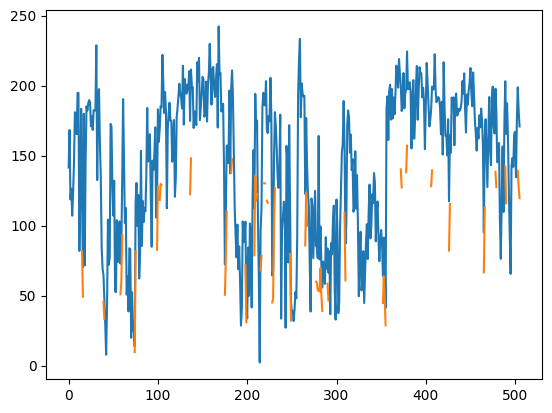

In [516]:
plt.plot(X_true)
plt.plot(np.where(Y< X_true, Y, -np.inf))

## Train with Linear Regression Method

In [518]:
beta_lr = inv(A.T@A)@A.T@Y
print("Trained", np.round(beta_lr.T, 2))
print("True", beta.T)
print("It differs quite a lot.")

Trained [[ 2.57  1.84 -0.75]]
True [[ 3.   2.  -0.9]]
It differs quite a lot.


## Train with Censored Regression Method

In [519]:
def get_H(v):
    a =  norm.pdf(v) / (1 - norm.cdf(v))
    return a

def get_Hn(c, A, beta_n, sigma_n):
    return get_H((c - A@beta_n)/sigma_n)

def get_In(C, Y):
    return column_indicator(C == Y)

In [520]:

def inner_product(v1: np.ndarray, v2: np.ndarray, save = True) -> float:
    if save:
        v1 = np.where(np.isinf(v1), 0, v1)
        v2 = np.where(np.isinf(v2), 0, v2)
    return np.dot(v1.T, v2)



In [521]:
def update_em(data, theta):
    # Reading data
    y, c, A = data
    m = A.shape[1]

    # Load paramter
    beta_n, sigma2_n = column_vector(theta[:m]), theta[m]
    sigma_n = np.sqrt(sigma2_n)

    # Compute
    In = get_In(c, y)
    Hn =  get_Hn(c, A, beta_n, sigma_n)
    Hn = np.where(np.isinf(Hn), 3, Hn)
    censored_adj = np.where( np.isnan(Hn * In), 0, Hn * In)
    censored_adj[np.abs(censored_adj) < 1e-6] = 0

    beta_np1 = inv(A.T@A)@A.T@(A@beta_n + sigma_n * censored_adj)

    # Compute
    r = Y.shape[0]
    sigma2_np1 = sigma2_n + 1/r * (
            inner_product(A@beta_n, A@beta_n) 
            - 2 * inner_product( A@beta_np1, A@beta_n + sigma_n* censored_adj)
            + inner_product(A@beta_np1, A@beta_np1)
            + inner_product(c + A@beta_n, sigma_n * censored_adj)
    )
    theta_np1 = np.append(beta_np1, sigma2_np1)
    print(theta_np1)
    return theta_np1

In [522]:
data = (Y, C, A)
theta0 = np.append(beta_lr, 2)
theta = theta0
print("theta0", theta0)
print("theta0", beta.T)

theta0 [ 2.5701353   1.8400873  -0.75019384  2.        ]
theta0 [[ 3.   2.  -0.9]]


In [526]:
model = em.EM(n_iter = 50000)
model.load(data, update_em)
a = model.fit(theta0)

/var/folders/b_/ps8r7v4s6fbbssck5mf0m9w40000gn/T/ipykernel_17665/3975438309.py:2: RuntimeWarning: divide by zero encountered in divide
  a =  norm.pdf(v) / (1 - norm.cdf(v))
/var/folders/b_/ps8r7v4s6fbbssck5mf0m9w40000gn/T/ipykernel_17665/3975438309.py:2: RuntimeWarning: invalid value encountered in divide
  a =  norm.pdf(v) / (1 - norm.cdf(v))


[ 2.57543085  1.83955047 -0.74931473  2.00509196]
[ 2.58065842  1.83902038 -0.74844594  2.00995507]
[ 2.58581936  1.83849689 -0.74758729  2.01459648]
[ 2.590915    1.83797988 -0.7467386   2.01902312]
[ 2.59594661  1.83746922 -0.7458997   2.02324166]
[ 2.60091545  1.83696479 -0.74507043  2.02725852]
[ 2.60582273  1.83646648 -0.74425063  2.03107993]
[ 2.61066961  1.83597417 -0.74344013  2.03471189]
[ 2.61545725  1.83548776 -0.74263878  2.03816019]
[ 2.62018676  1.83500713 -0.74184643  2.04143043]
[ 2.62485922  1.83453218 -0.74106294  2.04452802]
[ 2.62947568  1.8340628  -0.74028815  2.0474582 ]
[ 2.63403717  1.83359891 -0.73952192  2.05022601]
[ 2.63854468  1.83314039 -0.73876412  2.05283635]
[ 2.6429992   1.83268717 -0.73801462  2.05529395]
[ 2.64740166  1.83223914 -0.73727328  2.05760339]
[ 2.65175299  1.83179621 -0.73653996  2.0597691 ]
[ 2.65605408  1.83135831 -0.73581456  2.06179537]
[ 2.66030582  1.83092533 -0.73509693  2.06368636]
[ 2.66450905  1.8304972  -0.73438697  2.06544608]


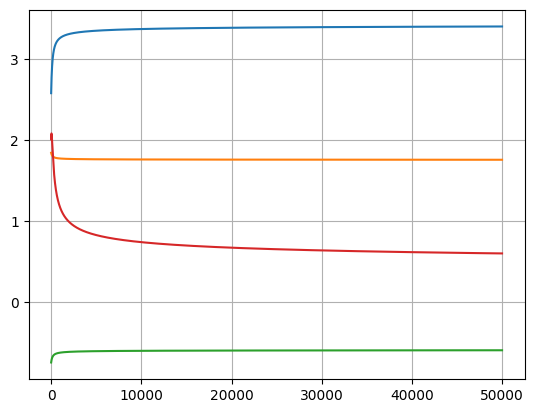

In [527]:
plt.plot(a)
plt.grid(True)

In [525]:
beta

array([[ 3. ],
       [ 2. ],
       [-0.9]])

In [528]:
beta_lr

array([[ 2.5701353 ],
       [ 1.8400873 ],
       [-0.75019384]])